<div dir="rtl">

# למידת חיזוק במערכת פיזיקלית מתייצבת - אימון סביבת הסימולציה SimNet

**שם התלמיד:** אייל פורת  
**שם המורה:** שי פרח  
**תאריך:** אפריל 2025

`SimNet` היא רשת נוירונים שנועדה לאפשר גישור בין סביבת סימולציה ממוחשבת לעולם האמיתי, לאימון רלוונטי ואיכותי יותר של הסוכן.

הרעיון הכללי, הוא שנוסחאות הפיזיקה קרובות לתיאור הרובוט, אך חידוד של חיכוכים לא לינאריים, והתנהגויות שונות לא צפויות יתאפשר עם דיוק שיעשה  בשימוש בנתוני אמת מהרובוט.

`SimNet` מקבלת מצב (state) ופעולה (action) ומנסה לחזות את המצב הבא של המערכת.

מצב המערכת כולל:
- הזווית של הרובוט (0 - עומד ישר)
- המהירות הזוויתית של הרובוט
- הפעולה הקודמת שהפעיל המנוע

במחברת זו:
- נאסוף נתונים בשימוש במשוואות פיזיקה של הרובוט (מזכיר מטוטלת הפוכה).
- נאמן על הנתונים הללו את הרשת `SimNet`.
- נבצע כיוונון (fine-tuning) של `SimNet` על נתוני אמת שנאספו מהרובוט.
</div>

In [1]:
# Uncomment the following lines to run in Google Colab

# %cd /content
# !git clone https://github.com/EyalPorat/ddpg-balancing-robot.git
# %cd ddpg-balancing-robot
# !git checkout simpler-state-3
# %cd /content/ddpg-balancing-robot/python/notebooks

# import sys
# sys.path.append('/content/ddpg-balancing-robot/python')  # Add the repo root to Python path

<div dir="rtl">

## ייבוא ספריות - Import Libraries

In [2]:
import sys
sys.path.append('..')

import torch
import numpy as np
from pathlib import Path
import json
import yaml
import glob
from matplotlib import pyplot as plt
import seaborn as sns

from src.balancing_robot.models import SimNet
from src.balancing_robot.environment import BalancerEnv
from src.balancing_robot.training import SimNetTrainer
from src.balancing_robot.visualization import plot_predictions_comparison

<div dir="rtl">

## טעינת קונפיגורציה - Configuration Loading

תחילה נטען את קבצי הקונפיגורציה המכילים את פרמטרי האימון והסביבה. באמצעותם ניתן בשלוט באופי האימון מבלי לצלול לתוך הקוד.
</div>

In [3]:
# Load configurations
with open('../configs/simnet_config.yaml', 'r') as f:
    simnet_config = yaml.safe_load(f)

with open('../configs/env_config.yaml', 'r') as f:
    env_config = yaml.safe_load(f)

# Create directories
log_dir = Path('logs/simnet_training')
log_dir.mkdir(parents=True, exist_ok=True)

<div dir="rtl">

## אתחול המודל והסביבה - Initialization of the Model and Environment
</div>

In [4]:
# Set random seeds
torch.manual_seed(simnet_config['data_collection']['random_seed'])
np.random.seed(simnet_config['data_collection']['random_seed'])

# Create environment for physics data
env = BalancerEnv(config_path='../configs/env_config.yaml')

# Initialize trainer with config
trainer = SimNetTrainer(
    env=env,
    config_path='../configs/simnet_config.yaml'
)

c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


<div dir="rtl">

## איסוף נקודות מידע עם נוסחאות הפיזיקה - Collecting Data Points with Physics Equations

להבניית המידע הפיזיקלי הבסיסי למודל, נתחיל מאיסוף של דוגמאות מנוסחאות הפיזיקה.
</div>

In [5]:
# Collect physics simulation data
train_data, val_data = trainer.collect_physics_data()

print(f"Collected {len(train_data['states'])} training samples")
print(f"Collected {len(val_data['states'])} validation samples")

Collected 875870 training samples
Collected 218967 validation samples


<div dir="rtl">

## ניתוח הפיזור של נתוני הפיזיקה שאספנו - Analysis of the Distribution of the Collected Physics Data

נבצע ניתוח של התפלגות הנתונים כדי להבין טוב יותר את מרחב המצבים ולזהות אזורים שעשויים להיות חסרים.
</div>

Physics data distribution statistics:
  angle_range: (-1.6864, 1.6714)
  angle_mean: 0.0027
  angle_std: 0.8142
  angular_vel_range: (-6.2005, 6.4918)
  angular_vel_mean: 0.0029
  angular_vel_std: 2.9971
  num_samples: 875870.0000
  min_weight: 0.0000
  max_weight: 0.0000
  mean_weight: 0.0000
  std_weight: 0.0000


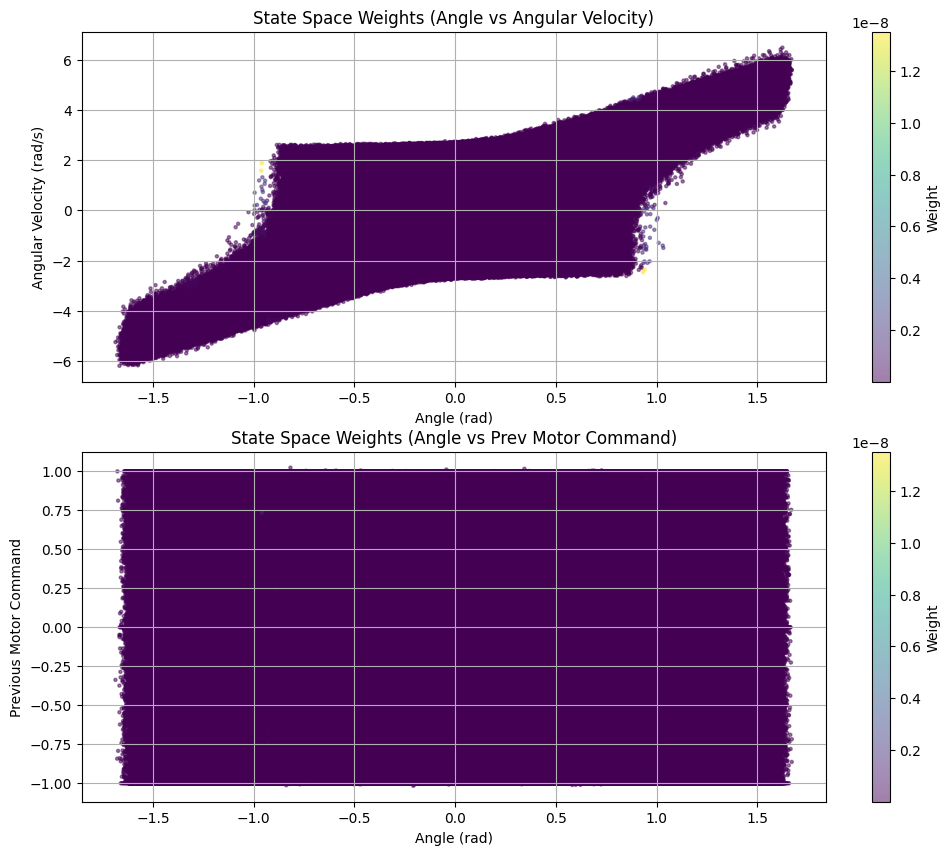

In [6]:
# Define class balancing parameters
num_bins = 10
strategy = "kmeans"

# Get distribution statistics
physics_distribution = SimNetTrainer.analyze_class_distribution(
    train_data, 
    num_bins=num_bins,
    strategy=strategy
)

print("Physics data distribution statistics:")
for key, value in physics_distribution.items():
    if isinstance(value, tuple):
        print(f"  {key}: ({value[0]:.4f}, {value[1]:.4f})")
    else:
        print(f"  {key}: {value:.4f}")

# Visualize class weights using angle and angular velocity
states = train_data['states']

# Create 2D scatter plot with first two dimensions (theta and theta_dot)
plt.figure(figsize=(12, 10))

# Create a figure with multiple subplots to show different state dimensions
plt.subplot(2, 1, 1)
weights = SimNetTrainer.calculate_class_weights(
    states, 
    num_bins=num_bins, 
    strategy=strategy
)
plt.scatter(states[:, 0], states[:, 1], c=weights, cmap='viridis', alpha=0.5, s=5)
plt.colorbar(label='Weight')
plt.title(f'State Space Weights (Angle vs Angular Velocity)')
plt.xlabel('Angle (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.grid(True)

# Add a subplot for the angle vs prev_motor_command
plt.subplot(2, 1, 2)
plt.scatter(states[:, 0], states[:, 2], c=weights, cmap='viridis', alpha=0.5, s=5)
plt.colorbar(label='Weight')
plt.title(f'State Space Weights (Angle vs Prev Motor Command)')
plt.xlabel('Angle (rad)')
plt.ylabel('Previous Motor Command')
plt.grid(True)

<div dir="rtl">

## שלב 1 - אימון המודל על נתוני נוסחאות הפיזיקה - Step 1: Training the Model on Physics Equations Data

</div>

In [7]:
# Train on physics data
physics_history = trainer.train(
    train_data=train_data,
    val_data=val_data,
    is_finetuning=False,
    log_dir=log_dir / 'physics'
)

Epoch 1/30 - Train Loss: 0.955264 - Val Loss: 0.318307
Epoch 2/30 - Train Loss: 0.156282 - Val Loss: 0.058873
Epoch 3/30 - Train Loss: 0.030380 - Val Loss: 0.014837
Epoch 4/30 - Train Loss: 0.009528 - Val Loss: 0.006078
Epoch 5/30 - Train Loss: 0.004604 - Val Loss: 0.003498
Epoch 6/30 - Train Loss: 0.002948 - Val Loss: 0.002446
Epoch 7/30 - Train Loss: 0.002172 - Val Loss: 0.001884
Epoch 8/30 - Train Loss: 0.001741 - Val Loss: 0.001567
Epoch 9/30 - Train Loss: 0.001486 - Val Loss: 0.001367
Epoch 10/30 - Train Loss: 0.001318 - Val Loss: 0.001231
Epoch 11/30 - Train Loss: 0.001199 - Val Loss: 0.001133
Epoch 12/30 - Train Loss: 0.001111 - Val Loss: 0.001058
Epoch 13/30 - Train Loss: 0.001044 - Val Loss: 0.001000
Epoch 14/30 - Train Loss: 0.000991 - Val Loss: 0.000952
Epoch 15/30 - Train Loss: 0.000948 - Val Loss: 0.000912
Epoch 16/30 - Train Loss: 0.000912 - Val Loss: 0.000878
Epoch 17/30 - Train Loss: 0.000880 - Val Loss: 0.000848
Epoch 18/30 - Train Loss: 0.000852 - Val Loss: 0.000822
E

In [8]:
# Save physics trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_physics_final.pt')

simnet_physics = SimNet(
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.shape[0],
    hidden_dims=simnet_config['model']['hidden_dims']
)
simnet_physics.load_state_dict(torch.load(log_dir / 'simnet_physics_final.pt')['state_dict'])

<All keys matched successfully>

<div dir="rtl">

## טעינה ועיבוד של נתוני אמת מהרובוט - Loading and Processing Real-World Robot Data

</div>

In [9]:
# Find all files that start with robot_logs and end with .json
log_files = glob.glob("../data/robot_logs*.json")
print(f"Found {len(log_files)} log files: {log_files}")

# Initialize empty list to store all episodes
all_episodes = []

# Load and append data from each file
for log_file in log_files:
    with open(log_file, "r") as f:
        log_data = json.load(f)
        # Append episodes from this file
        # drop the first and last data point from each episode
        for episode in log_data["episodes"]:
            for key in episode.keys():
                if isinstance(episode[key], list):  # Check if the value is a list
                    episode[key] = episode[key][1:-1]
        # Append the modified episode to all_episodes
        all_episodes.extend(log_data["episodes"])
        print(f"Loaded {len(log_data['episodes'])} episodes from {log_file}")

# Process combined data
real_train_data, real_val_data = trainer.process_real_data(all_episodes)
print(f"Processed {len(real_train_data['states'])} real training samples")
print(f"Processed {len(real_val_data['states'])} real validation samples")

real_train_data = trainer.clean_data_exceptions(real_train_data, 6)
print(f"Cleaned real training data: {len(real_train_data['states'])} samples")

Found 12 log files: ['../data\\robot_logs_20250308_205032_no_motor.json', '../data\\robot_logs_20250322_234124_with_motor_fixed.json', '../data\\robot_logs_20250322_234707_no_motor_fixed.json', '../data\\robot_logs_20250323_000931_no_motor_fixed.json', '../data\\robot_logs_20250323_001127_with_motor.json', '../data\\robot_logs_20250323_013709_with_motor_fixed.json', '../data\\robot_logs_20250410_183727_with_motor.json', '../data\\robot_logs_20250410_183913_no_motor.json', '../data\\robot_logs_20250426_165815_with_motor.json', '../data\\robot_logs_20250426_170447_with_motor.json', '../data\\robot_logs_20250426_173305_with_motor.json', '../data\\robot_logs_20250427_123932_with_action.json']
Loaded 40 episodes from ../data\robot_logs_20250308_205032_no_motor.json
Loaded 11 episodes from ../data\robot_logs_20250322_234124_with_motor_fixed.json
Loaded 38 episodes from ../data\robot_logs_20250322_234707_no_motor_fixed.json
Loaded 11 episodes from ../data\robot_logs_20250323_000931_no_motor_f

<div dir="rtl">

# הצגה וניתוח של נתוני האמת - Visualization and Analysis of Real-World Data

נציג בגרף של ערך לזמן, את הפרקים שנאספו מהרובוט. נבחן גרפים של הזווית, המהירות הזוויתית ופלט המנוע.
</div>

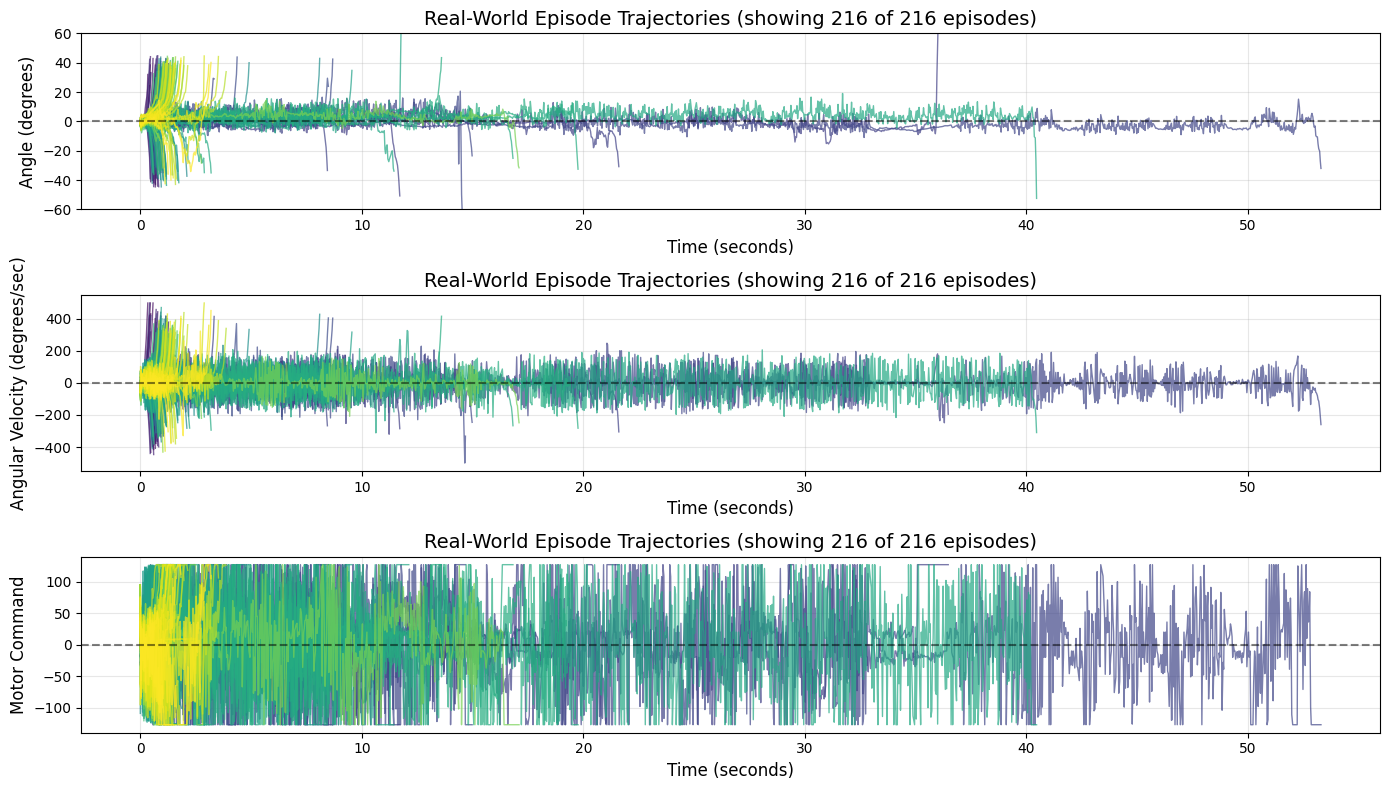

In [10]:
# Plot trajectories of all real-world episodes (angle vs time)
plt.figure(figsize=(14, 8))

# Track the number of plotted episodes
plotted_episodes = 0
max_episodes_to_show = 10000  # Limit to avoid overcrowding

# Define color palette for better visualization
colors = plt.cm.viridis(np.linspace(0, 1, min(len(all_episodes), max_episodes_to_show)))

# Iterate through all real-world episodes
for i, episode in enumerate(all_episodes):
    # Skip if we've reached the limit
    if plotted_episodes >= max_episodes_to_show:
        break

    # Extract states
    if "states" not in episode or not episode["states"]:
        continue

    states = episode["states"]

    # Extract timestamps and angles
    timestamps = []
    angles_deg = []
    angular_vels_dps = []
    motor_commands = []

    # Get the initial timestamp to normalize
    if len(states) > 0 and "timestamp" in states[0]:
        start_time = states[0]["timestamp"]
    else:
        continue  # Skip if no timestamp

    # Process each state
    for state in states:
        if "timestamp" in state and "theta" in state:
            # Convert to seconds from start of episode
            time_sec = (state["timestamp"] - start_time) / 1000.0
            # Convert angle to degrees
            angle_deg = state["theta"] * 180 / np.pi
            # Convert angular velocity to degrees per second
            angular_vel_degps = state["theta_dot"] * 180 / np.pi

            timestamps.append(time_sec)
            angles_deg.append(angle_deg)
            angular_vels_dps.append(angular_vel_degps)
            motor_commands.append(state["motor_pwm"])

    plt.subplot(3, 1, 1)
    plt.plot(timestamps, angles_deg, color=colors[plotted_episodes], alpha=0.7, linewidth=1.0)
    plt.subplot(3, 1, 2)
    plt.plot(timestamps, angular_vels_dps, color=colors[plotted_episodes], alpha=0.7, linewidth=1.0)
    plt.subplot(3, 1, 3)
    plt.plot(timestamps, motor_commands, color=colors[plotted_episodes], alpha=0.7, linewidth=1.0)

    plotted_episodes += 1

# Customize plot
plt.subplot(3, 1, 1)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Angle (degrees)", fontsize=12)
plt.title(f"Real-World Episode Trajectories (showing {plotted_episodes} of {len(all_episodes)} episodes)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color="k", linestyle="--", alpha=0.5)  # Add horizontal line at 0 degrees (balanced position)

# Add y-axis limits to focus on typical balancing range
plt.ylim(-60, 60)  # Adjust based on your data

plt.subplot(3, 1, 2)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Angular Velocity (degrees/sec)", fontsize=12)
plt.title(f"Real-World Episode Trajectories (showing {plotted_episodes} of {len(all_episodes)} episodes)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color="k", linestyle="--", alpha=0.5)  # Add horizontal line at 0 degrees (balanced position)

plt.subplot(3, 1, 3)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Motor Command", fontsize=12)
plt.title(f"Real-World Episode Trajectories (showing {plotted_episodes} of {len(all_episodes)} episodes)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color="k", linestyle="--", alpha=0.5)  # Add horizontal line at 0 degrees (balanced position)


plt.tight_layout()
plt.savefig(log_dir / "real_world_trajectories.png")
plt.show()

<div dir="rtl">

# ניתוח ואיזון התפלגות נתוני האמת - Analysis and Balance of Real-World Data Distribution

ביחס לנתונים שנאספו מנוסחאות הפיזיקה, שנוצרו בצורה אחידה, נתוני האמת יכולים להיות מפוזרים אחרת, ודלילים יותר במקומות מסוימים. לקבלת אימון איכותי נאזן אותם.
</div>

Real-world data distribution statistics:
  angle_range: (-0.7019, 0.6413)
  angle_mean: 0.0275
  angle_std: 0.1177
  angular_vel_range: (-5.9773, 7.5193)
  angular_vel_mean: 0.0677
  angular_vel_std: 1.3366
  num_samples: 12848.0000
  min_weight: 0.0000
  max_weight: 0.0000
  mean_weight: 0.0000
  std_weight: 0.0000


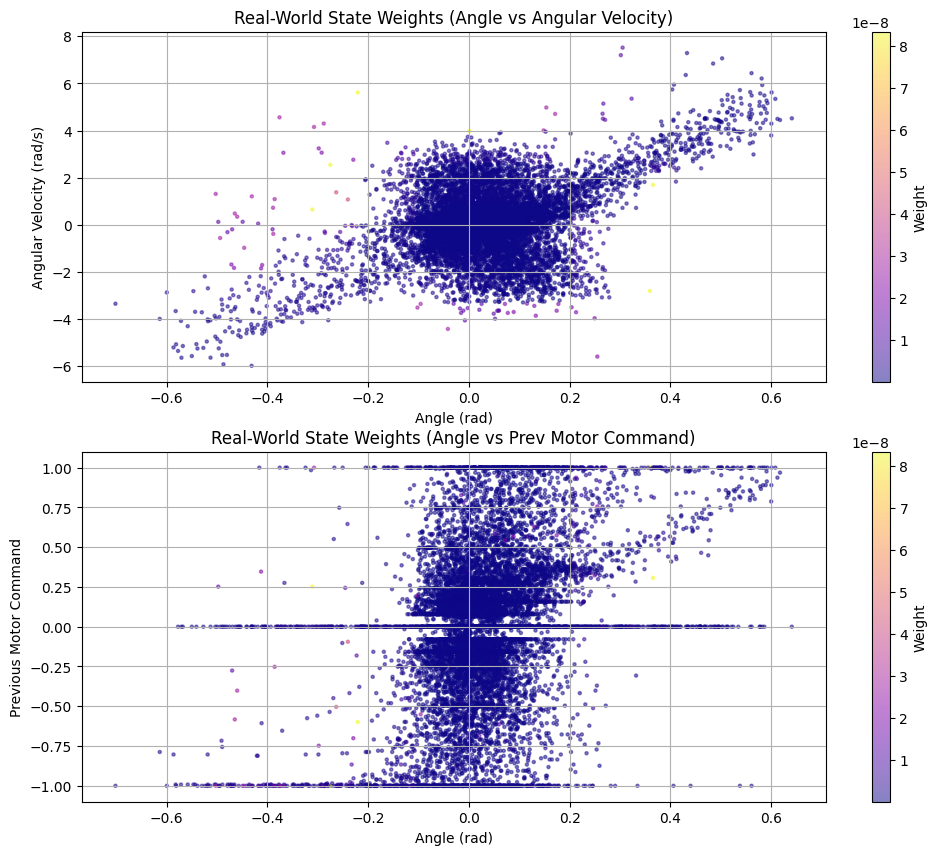

In [11]:
# Analyze the class distribution of real data
real_distribution = SimNetTrainer.analyze_class_distribution(real_train_data, num_bins=num_bins, strategy=strategy)

print("Real-world data distribution statistics:")
for key, value in real_distribution.items():
    if isinstance(value, tuple):
        print(f"  {key}: ({value[0]:.4f}, {value[1]:.4f})")
    else:
        print(f"  {key}: {value:.4f}")

# Visualize class weights for real data
real_states = real_train_data["states"]
real_weights = SimNetTrainer.calculate_class_weights(real_states, num_bins=num_bins, strategy=strategy)

# Create multi-dimensional visualization for real data
plt.figure(figsize=(12, 10))

# Plot angle vs angular velocity
plt.subplot(2, 1, 1)
plt.scatter(real_states[:, 0], real_states[:, 1], c=real_weights, cmap="plasma", alpha=0.5, s=5)
plt.colorbar(label="Weight")
plt.title(f"Real-World State Weights (Angle vs Angular Velocity)")
plt.xlabel("Angle (rad)")
plt.ylabel("Angular Velocity (rad/s)")
plt.grid(True)

# Plot angle vs previous motor command
plt.subplot(2, 1, 2)
plt.scatter(real_states[:, 0], real_states[:, 2], c=real_weights, cmap="plasma", alpha=0.5, s=5)
plt.colorbar(label="Weight")
plt.title(f"Real-World State Weights (Angle vs Prev Motor Command)")
plt.xlabel("Angle (rad)")
plt.ylabel("Previous Motor Command")
plt.grid(True)

In [12]:
# # Apply balancing to real data as well
# balanced_real_train_data = SimNetTrainer.create_balanced_dataset(
#     real_train_data, 
#     num_bins=num_bins, 
#     strategy=strategy
# )

# print(f"Original real dataset size: {len(real_train_data['states'])} samples")
# print(f"Balanced real dataset size: {len(balanced_real_train_data['states'])} samples")

# # Compare distributions with 3D state
# plt.figure(figsize=(12, 10))

# # Angle vs Angular Velocity for original data
# plt.subplot(2, 2, 1)
# plt.scatter(real_train_data['states'][:, 0], real_train_data['states'][:, 1], alpha=0.1, s=1)
# plt.title('Original Real Data (Angle vs AngVel)')
# plt.xlabel('Angle (rad)')
# plt.ylabel('Angular Velocity (rad/s)')
# plt.grid(True)

# # Angle vs Previous Motor Command for original data
# plt.subplot(2, 2, 2)
# plt.scatter(real_train_data['states'][:, 0], real_train_data['states'][:, 2], alpha=0.1, s=1)
# plt.title('Original Real Data (Angle vs MotorCmd)')
# plt.xlabel('Angle (rad)')
# plt.ylabel('Previous Motor Command')
# plt.grid(True)

# # Angle vs Angular Velocity for balanced data
# plt.subplot(2, 2, 3)
# plt.scatter(balanced_real_train_data['states'][:, 0], balanced_real_train_data['states'][:, 1], 
#             alpha=0.1, s=1, c='orange')
# plt.title('Balanced Real Data (Angle vs AngVel)')
# plt.xlabel('Angle (rad)')
# plt.ylabel('Angular Velocity (rad/s)')
# plt.grid(True)

# # Angle vs Previous Motor Command for balanced data
# plt.subplot(2, 2, 4)
# plt.scatter(balanced_real_train_data['states'][:, 0], balanced_real_train_data['states'][:, 2], 
#             alpha=0.1, s=1, c='orange')
# plt.title('Balanced Real Data (Angle vs MotorCmd)')
# plt.xlabel('Angle (rad)')
# plt.ylabel('Previous Motor Command')
# plt.grid(True)

# plt.tight_layout()
# plt.savefig(log_dir / "balanced_real_vs_original_distribution.png")
# plt.show()

<div dir="rtl">

# שלב 2 - כיוונון עדין של המודל על נתוני האמת - Step 2: Fine-Tuning the Model on Real-World Data

</div>

In [13]:
# Fine-tune on real data
real_history = trainer.train(
    train_data=real_train_data,
    val_data=real_val_data,
    is_finetuning=True,
    log_dir=log_dir / 'real'
)

Epoch 1/20 - Train Loss: 0.167294 - Val Loss: 0.122319
Epoch 2/20 - Train Loss: 0.137846 - Val Loss: 0.107722
Epoch 3/20 - Train Loss: 0.123118 - Val Loss: 0.098727
Epoch 4/20 - Train Loss: 0.113269 - Val Loss: 0.092264
Epoch 00035: reducing learning rate of group 0 to 5.0000e-06.
Epoch 5/20 - Train Loss: 0.105822 - Val Loss: 0.087180
Epoch 6/20 - Train Loss: 0.101087 - Val Loss: 0.085001
Epoch 7/20 - Train Loss: 0.098397 - Val Loss: 0.083060
Epoch 8/20 - Train Loss: 0.095997 - Val Loss: 0.081293
Epoch 9/20 - Train Loss: 0.093781 - Val Loss: 0.079616
Epoch 00040: reducing learning rate of group 0 to 2.5000e-06.
Epoch 10/20 - Train Loss: 0.091708 - Val Loss: 0.078022
Epoch 11/20 - Train Loss: 0.090176 - Val Loss: 0.077250
Epoch 12/20 - Train Loss: 0.089227 - Val Loss: 0.076537
Epoch 13/20 - Train Loss: 0.088320 - Val Loss: 0.075846
Epoch 14/20 - Train Loss: 0.087440 - Val Loss: 0.075186
Epoch 00045: reducing learning rate of group 0 to 1.2500e-06.
Epoch 15/20 - Train Loss: 0.086584 - Va

<div dir="rtl">

# הערכת עקומות הלמידה - Evaluation of Learning Curves

נבחן את עקומות הלמידה משני שלבי האימון - האימון על נתוני הפיזיקה והכיוונון על נתונים אמיתיים.

נשים לב שיש ירידה מצויינת בערך ההפסד (loss) הן עבור סט האימון, והן עבור סט הולידציה, מה שמעיד על כך שהמודל לא סובל מהתאמת יתר (overfitting).
</div>

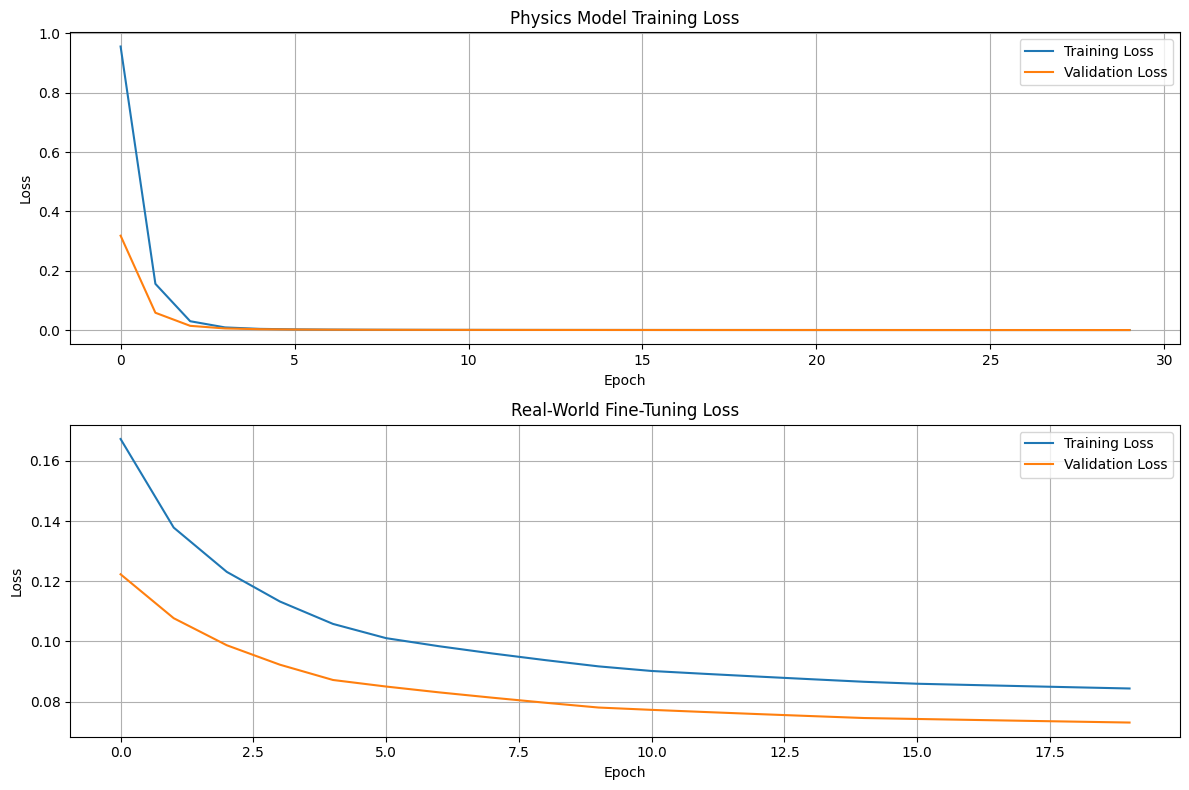

In [14]:
# Extract training losses from history data
physics_train_losses = [epoch['train_loss'] for epoch in physics_history]
physics_val_losses = [epoch['val_loss'] for epoch in physics_history]
real_train_losses = [epoch['train_loss'] for epoch in real_history]
real_val_losses = [epoch['val_loss'] for epoch in real_history]

# Create figure for loss plots
plt.figure(figsize=(12, 8))

# Plot physics training loss
plt.subplot(2, 1, 1)
plt.plot(physics_train_losses, label='Training Loss')
plt.plot(physics_val_losses, label='Validation Loss')
plt.title('Physics Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot real-world fine-tuning loss
plt.subplot(2, 1, 2)
plt.plot(real_train_losses, label='Training Loss')
plt.plot(real_val_losses, label='Validation Loss')
plt.title('Real-World Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(log_dir / "loss_curves.png")
plt.show()

<div dir="rtl">

# ניתוח תוצאות האימון - Analysis of Training Results

נביט בחיזויים של המודל המאומן על משוואות הפיזיקה, ועל המודל המכוונן, ביחס לחיזוי שמתבצע עם נוסחאות הפיזיקה.

בכל גרף ציר X יהיה הערך שנחזה עם נוסחאות הפיזיקה, ובציר Y יהיה חיזוי המודל. המקרה של התאמה מושלמת נצפה על קו אלכסוני (y=x).

ניתן לראות שהמודל המאומן על נוסחאות הפיזיקה מתאים בדיוק לנוסחאות הפיזיקה, כך שהאימון שלו היה מוצלח.

ניתן לראות את אי-ההסכמה של המודל המכוונן על נתוני האמת, מה שמסמן שנלמד שינוי מסויים, אותו רצינו למצוא. בתקווה, שינוי זה הוא הדיוק שחיפשנו לסימולציית הפיזיקה.
</div>

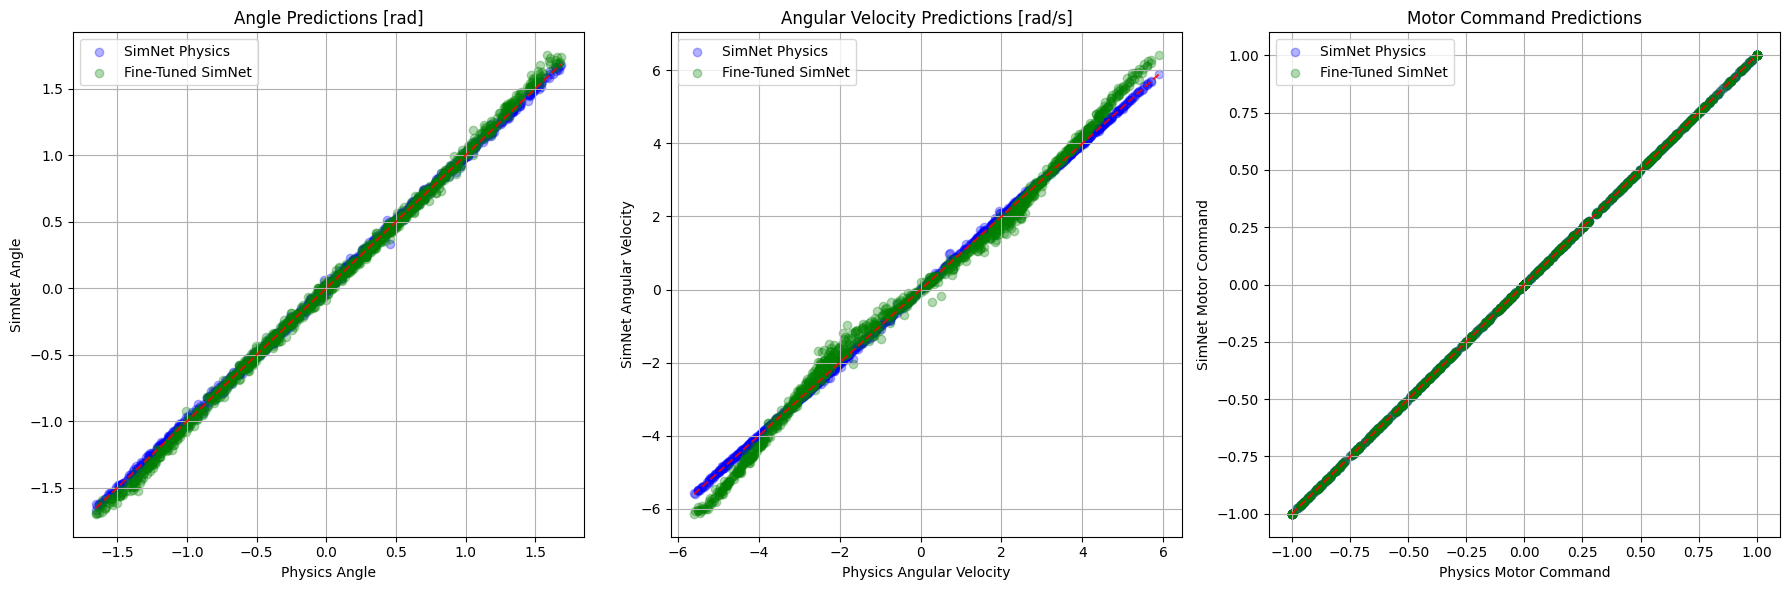

In [15]:
test_states = val_data["states"][:1000]
test_actions = val_data["actions"][:1000]
physics_preds = val_data["next_states"][:1000]  # The actual next states from the physics data

# Get SimNet predictions
simnet_preds = []
simnet_physics_preds = []
for s, a in zip(test_states, test_actions):
    s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    a_tensor = torch.tensor(a, dtype=torch.float32).unsqueeze(0)
    pred_next = trainer.simnet(s_tensor, a_tensor).detach().numpy()[0]
    simnet_preds.append(pred_next)
    pred_next_physics = simnet_physics(s_tensor, a_tensor).detach().numpy()[0]
    simnet_physics_preds.append(pred_next_physics)
simnet_preds = np.array(simnet_preds)
simnet_physics_preds = np.array(simnet_physics_preds)


# Custom function to plot 3D state predictions (focus on the first two elements)
def plot_3d_state_predictions(physics_preds, simnet_preds, simnet_physics_preds, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot angle predictions
    axes[0].scatter(physics_preds[:, 0], simnet_physics_preds[:, 0], alpha=0.3, label="SimNet Physics", color="blue")
    axes[0].scatter(physics_preds[:, 0], simnet_preds[:, 0], alpha=0.3, label="Fine-Tuned SimNet", color="green")
    min_val, max_val = min(physics_preds[:, 0]), max(physics_preds[:, 0])
    axes[0].plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
    axes[0].set_xlabel("Physics Angle")
    axes[0].set_ylabel("SimNet Angle")
    axes[0].set_title("Angle Predictions [rad]")
    axes[0].grid(True)
    axes[0].legend()

    # Plot angular velocity predictions
    axes[1].scatter(physics_preds[:, 1], simnet_physics_preds[:, 1], alpha=0.3, label="SimNet Physics", color="blue")
    axes[1].scatter(physics_preds[:, 1], simnet_preds[:, 1], alpha=0.3, label="Fine-Tuned SimNet", color="green")
    min_val, max_val = min(physics_preds[:, 1]), max(physics_preds[:, 1])
    axes[1].plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
    axes[1].set_xlabel("Physics Angular Velocity")
    axes[1].set_ylabel("SimNet Angular Velocity")
    axes[1].set_title("Angular Velocity Predictions [rad/s]")
    axes[1].grid(True)
    axes[1].legend()

    # Plot motor command predictions
    axes[2].scatter(physics_preds[:, 2], simnet_physics_preds[:, 2], alpha=0.3, label="SimNet Physics", color="blue")
    axes[2].scatter(physics_preds[:, 2], simnet_preds[:, 2], alpha=0.3, label="Fine-Tuned SimNet", color="green")
    min_val, max_val = min(physics_preds[:, 2]), max(physics_preds[:, 2])
    axes[2].plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
    axes[2].set_xlabel("Physics Motor Command")
    axes[2].set_ylabel("SimNet Motor Command")
    axes[2].set_title("Motor Command Predictions")
    axes[2].grid(True)
    axes[2].legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)

    return fig


# Use custom function for the 3D states
fig = plot_3d_state_predictions(
    physics_preds=physics_preds,
    simnet_preds=simnet_preds,
    simnet_physics_preds=simnet_physics_preds,
    save_path=log_dir / "prediction_comparison_3d.png",
)
plt.show()

<div dir="rtl">

# הערכת ביצועים במרחב המצבים - Evaluation of Performance in State-Space

נביט על ההבדלים בין המודלים עבור האיברים השונים במצב המערכת:
- בנתוני הזווית והמהירות הזוויתית, יש שינוי מסוים בין המודל המאומן על נוסחאות הפיזיקה, והמודל המכוונן על נתוני האמת.
- בנתוני פלט המנוע הקודם, אין שינוי כלל, וזה סימון טוב כיוון שנתוני פלט המנוע הקודם בכל שלב אמורים להיות זהים לפעולה שהופעלה במצב הקודם.
</div>

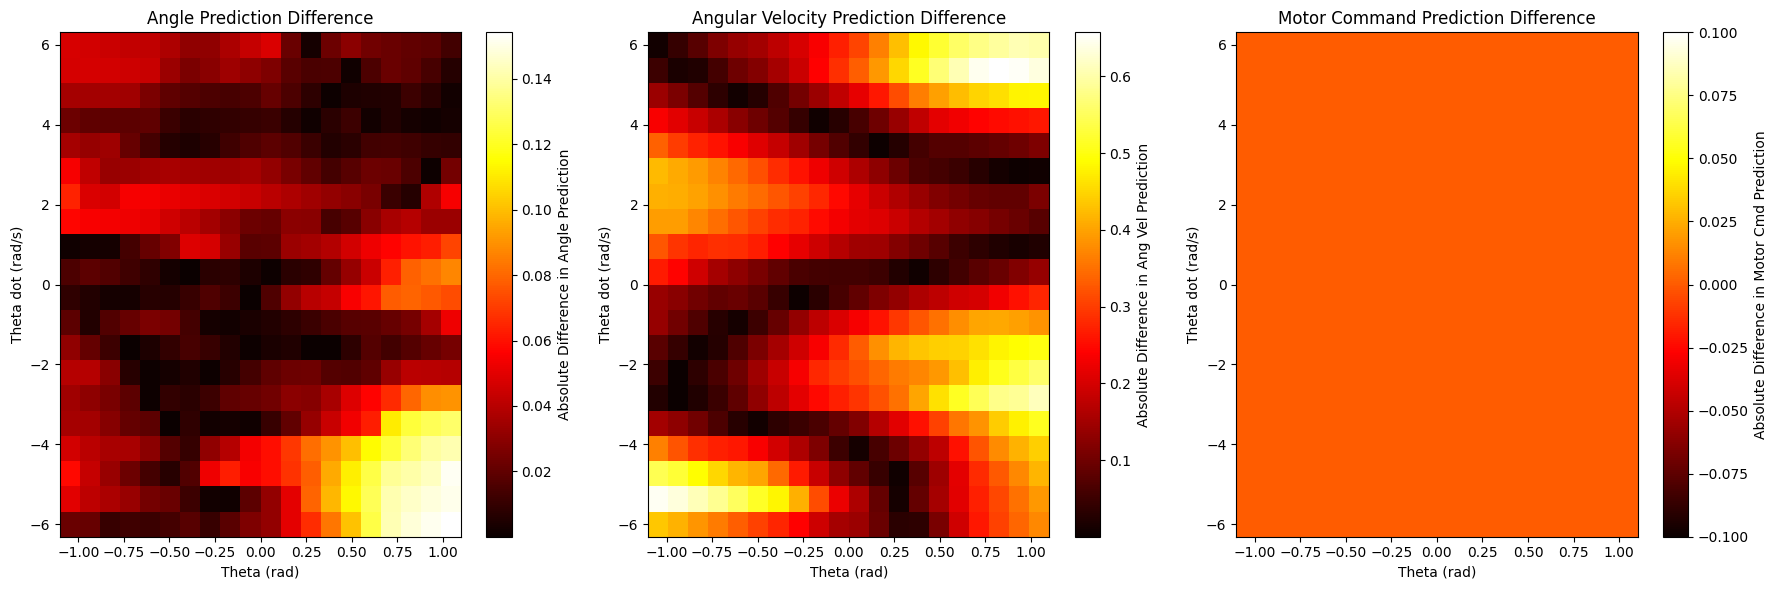

In [16]:
# Create a grid of test points across the state space for the first two dimensions
# Use a fixed value for the previous motor command dimension (0.0)
theta_range = np.linspace(-np.pi / 3, np.pi / 3, 20)
theta_dot_range = np.linspace(-6, 6, 20)
prev_cmd_value = 0.0  # Fixed value for previous motor command
theta_grid, theta_dot_grid = np.meshgrid(theta_range, theta_dot_range)

# Flatten the grid and add the third dimension (previous motor command)
test_grid_states = np.column_stack(
    (
        theta_grid.flatten(),
        theta_dot_grid.flatten(),
        np.ones(len(theta_grid.flatten())) * prev_cmd_value,  # Add fixed previous motor command
    )
)

# Test both models on this grid with a zero action
test_grid_actions = np.zeros((len(test_grid_states), 1))

# Get predictions from both models
grid_simnet_preds = []
grid_simnet_physics_preds = []

for s, a in zip(test_grid_states, test_grid_actions):
    s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    a_tensor = torch.tensor(a, dtype=torch.float32).unsqueeze(0)

    # Get prediction from fine-tuned model
    pred_next = trainer.simnet(s_tensor, a_tensor).detach().numpy()[0]
    grid_simnet_preds.append(pred_next)

    # Get prediction from physics-only model
    pred_next_physics = simnet_physics(s_tensor, a_tensor).detach().numpy()[0]
    grid_simnet_physics_preds.append(pred_next_physics)

grid_simnet_preds = np.array(grid_simnet_preds)
grid_simnet_physics_preds = np.array(grid_simnet_physics_preds)

# Calculate the absolute difference between the models
prediction_diff = np.abs(grid_simnet_preds - grid_simnet_physics_preds)
diff_angle = prediction_diff[:, 0].reshape(theta_dot_grid.shape)
diff_angular_vel = prediction_diff[:, 1].reshape(theta_dot_grid.shape)
diff_motor_cmd = prediction_diff[:, 2].reshape(theta_dot_grid.shape)

# Plot the difference as a heatmap
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.pcolormesh(theta_grid, theta_dot_grid, diff_angle, cmap="hot")
plt.colorbar(label="Absolute Difference in Angle Prediction")
plt.title("Angle Prediction Difference")
plt.xlabel("Theta (rad)")
plt.ylabel("Theta dot (rad/s)")

plt.subplot(1, 3, 2)
plt.pcolormesh(theta_grid, theta_dot_grid, diff_angular_vel, cmap="hot")
plt.colorbar(label="Absolute Difference in Ang Vel Prediction")
plt.title("Angular Velocity Prediction Difference")
plt.xlabel("Theta (rad)")
plt.ylabel("Theta dot (rad/s)")

plt.subplot(1, 3, 3)
plt.pcolormesh(theta_grid, theta_dot_grid, diff_motor_cmd, cmap="hot")
plt.colorbar(label="Absolute Difference in Motor Cmd Prediction")
plt.title("Motor Command Prediction Difference")
plt.xlabel("Theta (rad)")
plt.ylabel("Theta dot (rad/s)")

plt.tight_layout()
plt.savefig(log_dir / "prediction_difference_heatmap.png")
plt.show()

<div dir="rtl">

# שמירת המודל הסופי - Final Model Saving

</div>

In [17]:
# Save trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'real_history': real_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_final.pt')